In [90]:
dir_map = {
    0: '>',
    1: 'v',
    2: '<',
    3: '^'
}

move_dir_map = {
    (0, 1): 0,
    (1, 0): 1,
    (0, -1): 2,
    (-1, 0): 3
}

move_to_dir = lambda move: move_dir_map[move]

dir_map_inv = {v: k for k, v in dir_map.items()}
move_list = [(0, 1), (0, -1), (1, 0), (-1, 0)]

def get_90_deg_moves(move): return [
    move_list[(move + 1) % 4], move_list[(move - 1) % 4]]

def out_of_bounds(i, j, maze):
    return i < 0 or j < 0 or i >= len(maze) or j >= len(maze[0])

In [95]:
import numpy as np
import heapq
import matplotlib.pyplot as plt

class Node():
    def __init__(self, pos: tuple[int, int], dir: int, is_start: bool = False, is_end: bool = False):
        self.is_start = is_start
        self.is_end = is_end
        self.pos = pos
        self.dir = dir
        self.children = []

    def __add__(self, move: tuple[int, int]) -> tuple[int, int]:
        return self.pos[0] + move[0], self.pos[1] + move[1]
    
    def __lt__(self, other):
        self.pos < other.pos
    
    def __str__(self):
        return f'{self.pos} {dir_map[self.dir]}'
    
    def __repr__(self):
        return self.__str__()

class Maze():
    def __init__(self, dims: tuple[int, int], maze: np.ndarray[np.ndarray[list[Node]]], start_node: Node, end: tuple[int, int]):
        self.dims = dims
        self.maze = maze
        self.start_node = start_node     
        self.end = end

    def a_star(self):
        open_set = []
        closed_list = []
        heapq.heappush(open_set, (0, self.start_node))
        came_from = {}
        g_cost = {}
        g_cost[(self.start_node.pos, self.start_node.dir)] = 0

        while len(open_set) > 0:
            current_node = open_set.pop(0)[1]
            closed_list.append(current_node)

            if current_node.is_end:
                return self.reconstruct_path(came_from, current_node)

            for neighbor in self.get_legal_moves(current_node):
                if neighbor in closed_list:
                    continue

                cost = self.calc_cost(current_node, neighbor)
                new_cost = g_cost[(current_node.pos, current_node.dir)] + cost

                if new_cost < g_cost.get((neighbor.pos, neighbor.dir), float('inf')):
                    g_cost[(neighbor.pos, neighbor.dir)] = new_cost
                    priority = new_cost + self.heuristic(neighbor, self.end)
                    heapq.heappush(open_set, (priority, neighbor))
                    came_from[(neighbor.pos, neighbor.dir)] = current_node
                
        return None

    def reconstruct_path(self, came_from: dict[tuple[tuple[int, int], int], Node], current: Node) -> list[Node]:
        total_path = [current]
        while (current.pos, current.dir) in came_from:
            current = came_from[(current.pos, current.dir)]
            total_path.append(current)
        return total_path[::-1]
    
    def heuristic(self, n1: Node, end: tuple[int, int]) -> int:
        # manhattan distance
        return abs(n1.pos[0] - end[0]) + abs(n1.pos[1] - end[1])
    
    def calc_cost(self, n1: Node, n2: Node):
        if abs(n1.pos[0]-n2.pos[0]) + abs(n1.pos[1]-n2.pos[1]) > 1:
            raise ValueError('Nodes must be adjacent')
        if n1.dir != n2.dir:
            return 1000
        else:
            return 1
    
    def get_legal_moves(self, node: Node) -> list[Node]:
        # can turn left, right, or go straight
        self_nodes = self.maze[node.pos[0]][node.pos[1]] # list of nodes at this position (different directions)
        legal_dirs = [(node.dir + 1) % 4, (node.dir - 1) % 4]
        legal_moves = []
        for self_node in self_nodes:
            if self_node.dir in legal_dirs:
                legal_moves.append(self_node)
        ahead_nodes = self.maze[node.pos[0] + move_list[node.dir][0]][node.pos[1] + move_list[node.dir][1]]
        for ahead_node in ahead_nodes:
            if ahead_node is not None and ahead_node.dir == node.dir:
                legal_moves.append(ahead_node)
                break
        return legal_moves

    def plot(self):
        plt.imshow([[0 if self.maze[i][j][0] is not None else 1 for j in range(self.dims[1])] for i in range(self.dims[0])])
        plt.show()
            
    def __str__(self):
        s = ''
        for i in range(self.dims[0]):
            for j in range(self.dims[1]):
                if i < len(self.maze) and j < len(self.maze[i]):
                    if self.maze[i][j][0] != None:
                        s += '.'
                    else:
                        s += '#'
            s += '\n'

        return s


In [ ]:
maze = []
dims = (0, 0)
with open('input.txt') as f:
    i = 0
    for line in f.readlines():
        row = []
        j = 0
        for c in line.strip():
            nodes = []
            for dir in ['^', 'v', '<', '>']:
                if c == '.':
                    nodes.append(Node((i, j), dir_map_inv[dir]))
                elif c == 'S':
                    if dir == '>':
                        start_node = Node((i, j), dir_map_inv[dir], is_start=True)
                        nodes.append(start_node)
                    else:
                        nodes.append(Node((i, j), dir_map_inv[dir]))
                elif c == 'E':
                    nodes.append(Node((i, j), dir_map_inv[dir], is_end=True))
                    end = (i, j)
                else:
                    nodes.append(None)
                # don't be tempted to break early, otherwise we have inhomogeneous rows
                
            row.append(np.array(nodes))
            j += 1
        maze.append(np.array(row))
        i += 1

    dims = (i, j)

maze = Maze(dims, maze, start_node, end)
optimal_path = maze.a_star()

37
[(13, 1), (12, 1), (11, 1), (11, 2), (11, 3), (11, 4), (11, 5), (10, 5), (9, 5), (8, 5), (7, 5), (7, 6), (7, 7), (7, 8), (7, 9), (7, 10), (7, 11), (8, 11), (9, 11), (10, 11), (11, 11), (12, 11), (13, 11), (13, 12), (13, 13), (12, 13), (11, 13), (10, 13), (9, 13), (8, 13), (7, 13), (6, 13), (5, 13), (4, 13), (3, 13), (2, 13), (1, 13)]


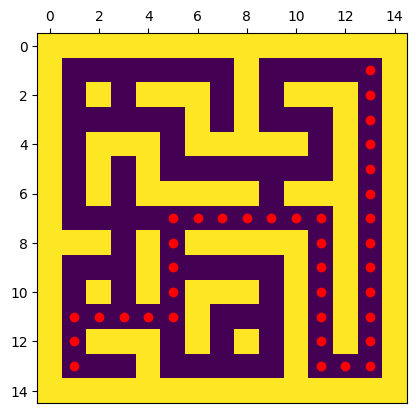

In [131]:
optimal_path = [o.pos for o in optimal_path]
# remove adjacent duplicates but retain order
optimal_path = [optimal_path[i] for i in range(len(optimal_path)) if i == 0 or optimal_path[i] != optimal_path[i-1]]
print(len(optimal_path))
print(optimal_path)

dir = start_node.dir
running_cost = 0

fig, ax = plt.subplots()
# place x axis at top
ax.xaxis.tick_top()
plt.plot(optimal_path[0][1], optimal_path[0][0], 'ro')
for i in range(len(optimal_path) - 1):
    # place unit in plot 
    plt.plot(optimal_path[i+1][1], optimal_path[i+1][0], 'ro')

maze.plot()

In [113]:

def count_turns(path: list[tuple[int, int]], start_dir: int) -> int:
    turns = 0
    for i in range(1, len(path)):
        move = (path[i][0] - path[i-1][0], path[i][1] - path[i-1][1])
        move_dir = move_to_dir(move)
        if move_dir != start_dir:
            turns += 1
        start_dir = move_dir
    return turns


turns = count_turns(optimal_path, start_node.dir)
score = len(optimal_path)-1 + turns * 1000
print(score)

print(f"turns: {turns}")

85424
turns: 85
